# Landelino Model

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy.modflow as mf
import flopy.utils as fu
import shutil
import json
from scipy.misc import imresize

%matplotlib inline

In [2]:
central_base_model_path = os.path.join('central-base-model')
landelino_model_path = os.path.join('landelino-model')

In [3]:
if os.path.exists(landelino_model_path):
    shutil.rmtree(landelino_model_path)
    
if not os.path.exists(landelino_model_path):
    os.makedirs(landelino_model_path)

In [4]:
extractRowsBetween = [6, 20]
extractColsBetween = [49, 60]
scaling_factor = 10

def scale(factor, array):
    if (len(array.shape) == 2):
        layer = []
        for row in array:
            newRow = np.array(list(map(lambda v: np.ones(factor) * v, row))).reshape(-1)
            for _ in range(factor): # or xrange if you are on 2.X
                layer.append(newRow)

        return layer
    
    if (len(array.shape) == 3):
        layers = []
        for layerData in array:
            layer = []
            for row in layerData:
                newRow = np.array(list(map(lambda v: np.ones(factor) * v, row))).reshape(-1)
                for _ in range(factor): # or xrange if you are on 2.X
                    layer.append(newRow)

            layers.append(layer)

        return layers

### Setup mf-package

In [5]:
modelname = 'landelina'
ml = mf.Modflow(modelname=modelname, exe_name='mf2005', version='mf2005', model_ws=landelino_model_path)

### Setup dis-package

In [6]:
nlay = 7
nrow = 140
ncol = 110

area_width_y = 1400
area_width_x = 1100

delc = area_width_x/ncol
delr = area_width_y/nrow

nper = 1

In [7]:
cbm = mf.Modflow.load("model.nam", model_ws=central_base_model_path, verbose=False, check=False, exe_name="mf2000")

In [8]:
top = cbm.dis.top.array[extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
top = scale(scaling_factor, top)

botm = cbm.dis.botm.array[:, extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
botm = scale(scaling_factor, botm)

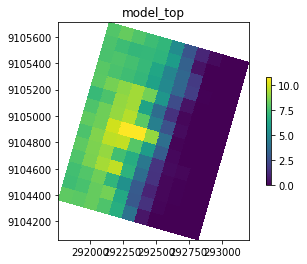

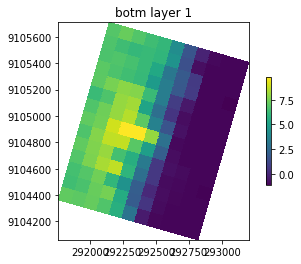

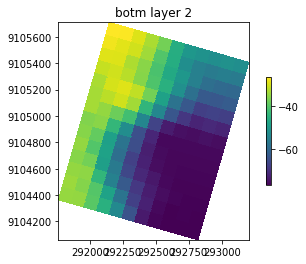

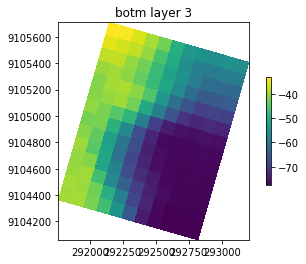

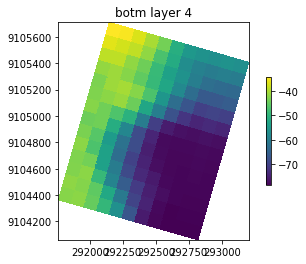

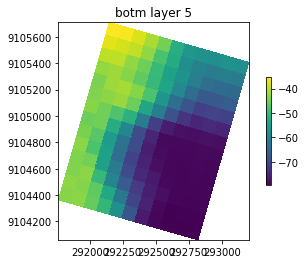

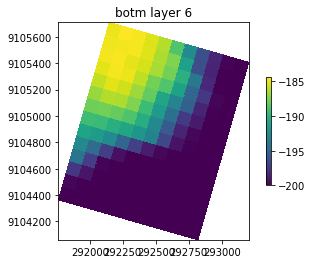

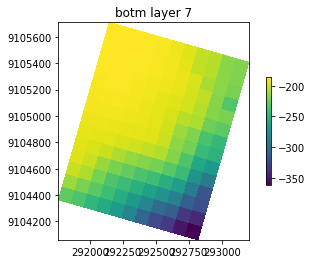

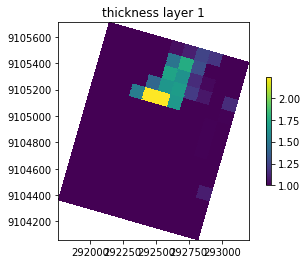

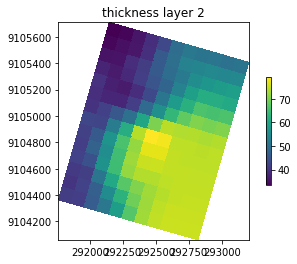

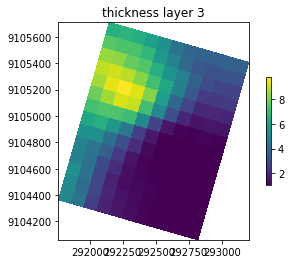

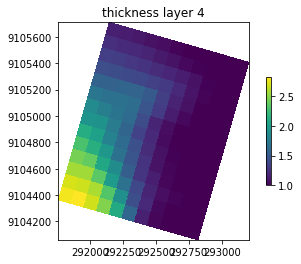

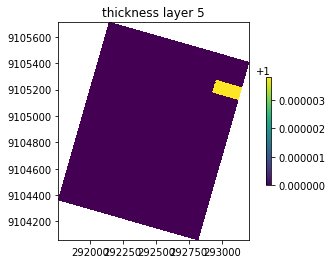

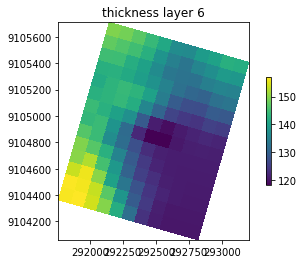

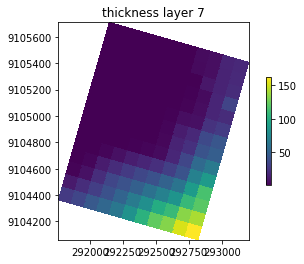

In [9]:
dis = mf.ModflowDis(
    ml, 
    nlay=nlay,
    nrow=nrow, 
    ncol=ncol, 
    delr=delr, 
    delc=delc, 
    top=top, 
    botm=botm, 
    nper=nper, 
    steady=False,
    proj4_str = 'EPSG:31985',
    xul = 292147.853,
    yul = 9105709.477,
    rotation = -16
)

dis.plot()

### Setup Basic-Package

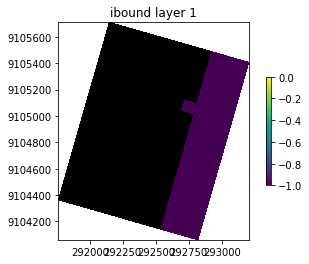

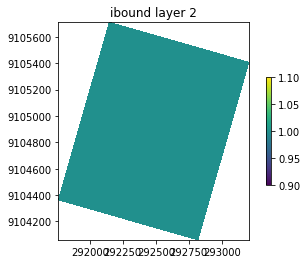

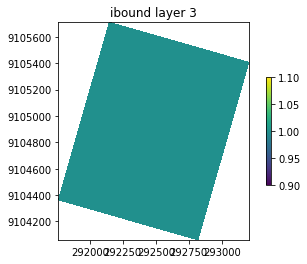

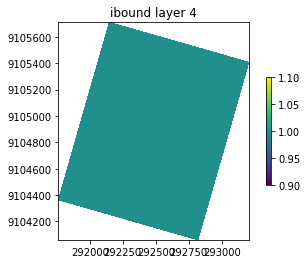

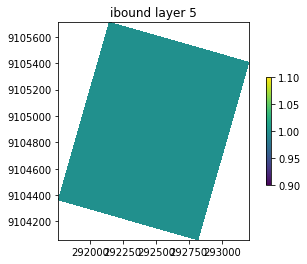

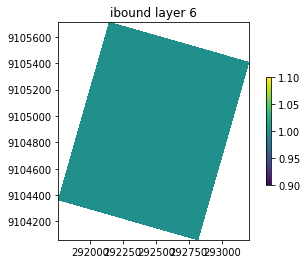

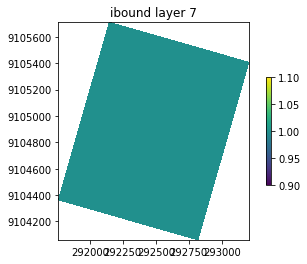

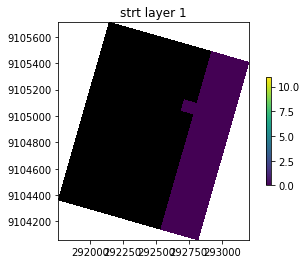

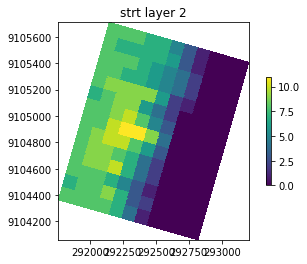

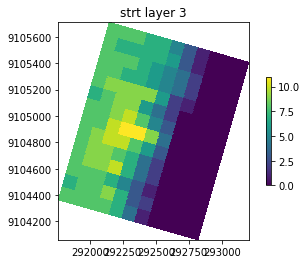

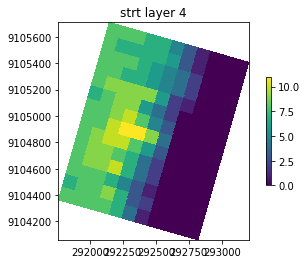

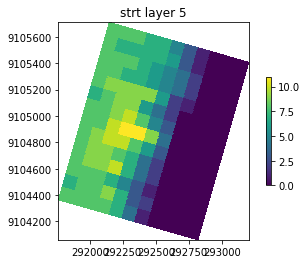

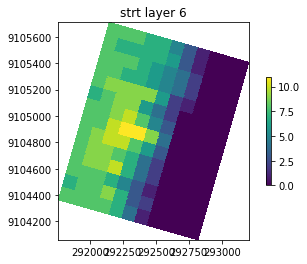

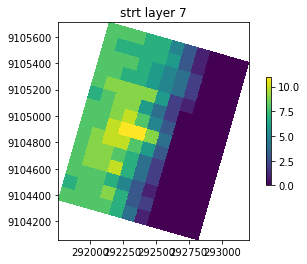

In [10]:
ibound = cbm.bas6.ibound.array[:, extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
ibound = scale(scaling_factor, ibound)

strt = cbm.bas6.strt.array[:, extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
strt = scale(scaling_factor, strt)
#print (json.dumps(h.tolist()))

bas = mf.ModflowBas(ml, ibound=ibound, strt=strt)
bas.plot()

### Setup General Head Boundaries

lets take the start values here and extract the values for each border and layer

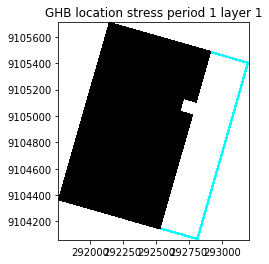

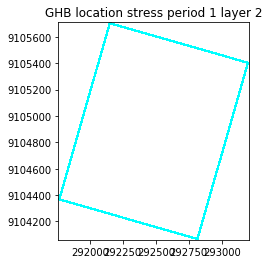

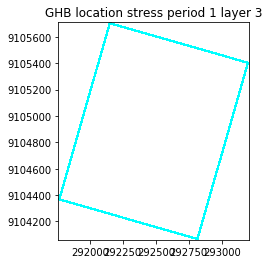

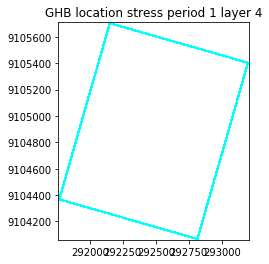

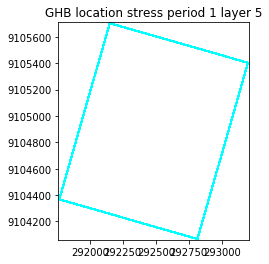

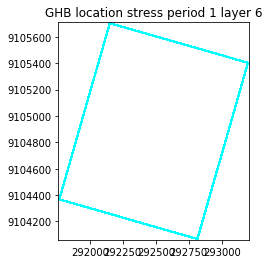

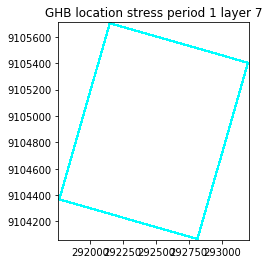

In [11]:
#  [lay, row, col, stage, cond]
mask_arr = np.zeros((nlay, nrow, ncol))
mask_arr[:, 0, :] = 1
mask_arr[:, -1, :] = 1
mask_arr[:, :, 0] = 1
mask_arr[:, :, -1] = 1

ghb_spd = {0: []}
for layer_id in range(nlay):
    for row_id in range(nrow):
        for col_id in range(ncol):
            if mask_arr[layer_id][row_id][col_id] == 1:
                ghb_spd[0].append([layer_id, row_id, col_id, strt[layer_id][row_id][col_id], 200])

ghb = mf.ModflowGhb(ml, stress_period_data=ghb_spd)
ghb.plot()

### Setup Recharge

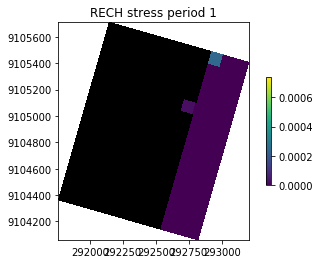

In [12]:
rch = cbm.rch.rech.array[0][:,extractRowsBetween[0]:extractRowsBetween[1], extractColsBetween[0]:extractColsBetween[1]]
rch = scale(scaling_factor,rch)
rech = {}
rech[0] = rch
rch = mf.ModflowRch(ml, rech=rech, nrchop = 3)

rch.plot()

### Setup the well boundary

Add wells here. Load from CSV and calculate layer.

In [13]:
well = pd.read_csv('model_wells_1.csv',delimiter = ';')
well['row'],well['column']
well['Rate[m^3/d']
welSp = {}
welSp[0] = []
for i in range(0,len(well['row'])):
    welSp[0].append([well['LAYER'][i]-1,well['row'][i]-1,well['column'][i]-1,well['Rate[m^3/d'][i]])
wel = mf.ModflowWel(ml, stress_period_data=welSp)

### Setup Flow-Package

In [14]:
data = pd.read_csv('HK.csv', delimiter = ';').dropna(axis = 1)
row = data['row']
col = data['column']
hk = np.ones((nlay, nrow, ncol))
for i in range(0,len(row)):
    hk[0,row[i]-1,col[i]-1] = data['KX_1'][i]
    hk[1,row[i]-1,col[i]-1] = data['KX_2'][i]
    hk[2,row[i]-1,col[i]-1] = data['KX_3'][i]
    hk[3,row[i]-1,col[i]-1] = data['KX_4'][i]
    hk[4,row[i]-1,col[i]-1] = data['KX_5'][i]
    hk[5,row[i]-1,col[i]-1] = data['KX_6'][i]
    hk[6,row[i]-1,col[i]-1] = data['KX_7'][i]
vka = np.ones((nlay, nrow, ncol))
for i in range(0,len(row)):
    vka[0,row[i]-1,col[i]-1] = data['KZ_1'][i]
    vka[1,row[i]-1,col[i]-1] = data['KZ_2'][i]
    vka[2,row[i]-1,col[i]-1] = data['KZ_3'][i]
    vka[3,row[i]-1,col[i]-1] = data['KZ_4'][i]
    vka[4,row[i]-1,col[i]-1] = data['KZ_5'][i]
    vka[5,row[i]-1,col[i]-1] = data['KZ_6'][i]
    vka[6,row[i]-1,col[i]-1] = data['KZ_7'][i]

laytyp = [1,1,1,1,1,1,1]

lpf = mf.ModflowLpf(ml, laytyp=laytyp, hk=hk, layavg = 0,layvka=0, vka=vka, sy = 0.3, ipakcb=53)

### Setup Solver Package and Output-control with defaults

In [15]:
pcg = mf.ModflowPcg(ml,rclose=1e-1)
oc = mf.ModflowOc(ml)

In [16]:
ml.write_input()
ml.run_model()

FloPy is using the following  executable to run the model: C:\modflow\Packages\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: landelina.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/11/26 11:59:25

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/11/26 11:59:26
 Elapsed run time:  1.188 Seconds

  Normal termination of simulation


(True, [])

### Read output file

In [17]:
hds = fu.HeadFile(os.path.join(landelino_model_path, modelname + '.hds'))
times = hds.get_times()

### Plot output file

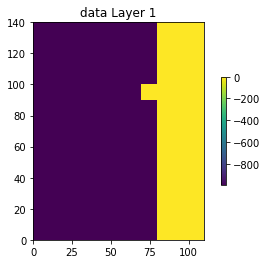

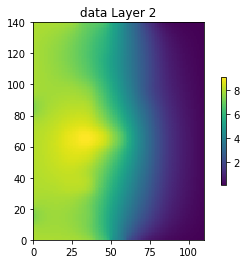

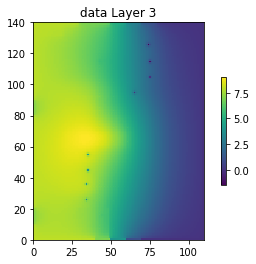

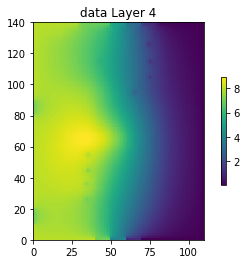

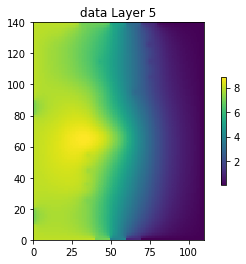

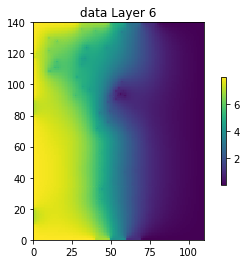

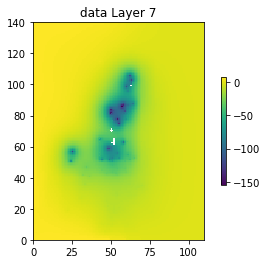

In [18]:
hds.plot(totim=times[-1], colorbar=True, masked_values=[-1e30])